# OUTLIER NOTEBOOK

In [341]:
import sys
sys.path.append("../notebooks/scripts/")

In [342]:
import altair as alt
from altair_saver import save
from augur.utils import json_to_tree
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import re
#from reportlab.graphics import renderPDF
import seaborn as sns
#from svglib.svglib import svg2rlg

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [343]:
alt.renderers.set_embed_options(
    padding={"left": 0, "right": 0, "bottom": 1, "top": 1}
)

RendererRegistry.enable('default')

In [344]:
sns.set_style("ticks")
# Disable top and right spines.
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
# Display and save figures at higher resolution for presentations and manuscripts.
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 100
# Display text at sizes large enough for presentations and manuscripts.
mpl.rcParams['font.weight'] = "normal"
mpl.rcParams['axes.labelweight'] = "normal"
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 8
mpl.rc('text', usetex=False)

In [345]:
try: 
    snakemake.input.node_df
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


## Pathogen-specific variables

Consider consolidating these into a single configuration file that can be passed to the notebook as a command line argument for more scriptable generation of these figures.

# Snakemake Specific Variables

In [367]:
try:
    node_df = snakemake.input.node_df

    pca_df = snakemake.input.pca_df
    explained_variance_pca = snakemake.input.explained_variance_pca

    mds_df = snakemake.input.mds_df

    #KDE Density:

    KDE_mds = snakemake.input.KDE_mds
    KDE_mds_metadata = snakemake.input.KDE_mds_metadata

except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


In [347]:
domain =  ['outlier', 'not_outlier'] 
range_ = ['#FF0000','#000000']

# Reading in all the data from the scripts

In [348]:
import os

os.getcwd()

'/mnt/c/Work/BedfordProjects/cartography/outlier_analysis'

In [349]:
#node_df = pd.read_csv(node_df, sep="\t")
metadata_df = pd.read_csv("results/total_metadata.tsv", sep="\t")
node_df = pd.read_csv("results/table.tsv", sep="\t")

In [350]:
metadata_df

strain        date accession country region  \
0                    A/Alabama/01/2017  2017-01-04  CY216617     USA      N   
1                    A/Alabama/02/2015  2015-01-26  KT836052     USA      N   
2                    A/Alabama/02/2016  2016-01-27  KX412662     USA      N   
3                    A/Alabama/02/2017  2017-01-05  CY216609     USA      N   
4                    A/Alabama/03/2017  2017-01-19  CY216625     USA      N   
...                                ...         ...       ...     ...    ...   
9573   A/swine/Virginia/A02478454/2019  2019-04-26  MK967619     USA      N   
9574   A/swine/Virginia/A02478581/2019  2019-04-22  MN436839     USA      N   
9575   A/swine/Virginia/A02478738/2019  2019-08-29  MN608561     USA      N   
9576  A/swine/Wisconsin/A02140875/2018  2018-01-19  MG977436     USA      N   
9577    A/swine/Wyoming/A02245222/2019  2019-08-23  MN543888     USA      N   

          outlier  
0     not_outlier  
1     not_outlier  
2     not_outlier  
3     not_outlier  
4     not_outlier  
...           ...  
9573      outlier  
9574      outlier  
9575      outlier  
9576      outlier  
9577      outlier  

[9578 rows x 6 columns]

In [351]:
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)

In [352]:
node_df.head()

strain     date  pca1  pca2  pca3  pca4  \
0     A/swine/Minnesota/A01785788/2018  2018.95  5.07 -0.68  5.79  4.72   
1  A/swine/BritishColumbia/SD0286/2018  2018.27  4.99  1.09  4.89  7.37   
2     A/swine/Saskatchewan/SD0271/2018  2018.18  4.92  1.34  5.02  7.07   
3          A/swine/Manitoba/D0524/2018  2018.05  5.73 -1.07  4.78  5.65   
4      A/swine/Nebraska/A02256553/2018  2018.62  6.13 -0.13  4.59  5.08   

     mds1    mds2  tsne_x  tsne_y  umap_x  umap_y clade_membership  pca_label  \
0  134.07 -162.40   -6.03    6.34    4.12   25.35       unassigned          0   
1  188.91 -113.46   -5.95    5.19    4.18   25.14       unassigned          0   
2  192.03   91.91   -5.96    5.20    4.28   25.13       unassigned          0   
3  -24.46  207.28   -5.05    6.89    4.04   25.35       unassigned          0   
4  129.52  176.69   -5.09    7.28    4.07   25.07       unassigned          0   

   mds_label  umap_label  t-sne_label  y  
0         -1           2           18  1  
1         -1           2           18  2  
2         -1           2           18  3  
3         -1           2           18  4  
4         -1           2           18  5

In [353]:
node_df = node_df.merge(metadata_df[["strain", "outlier"]], on="strain")

# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [14]:
#principalDf = pd.read_csv(pca_df, index_col=0)
principalDf = pd.read_csv("results/embed_pca.csv", index_col=0)

In [94]:
#explained_variance_df = pd.read_csv(explained_variance_pca)
explained_variance_df = pd.read_csv("results/explained_variance_pca.csv")
explained_variance_df

explained variance  principal components
0              0.1835                     1
1              0.1314                     2
2              0.1053                     3
3              0.0779                     4
4              0.0509                     5
5              0.0350                     6
6              0.0247                     7
7              0.0223                     8
8              0.0208                     9
9              0.0180                    10

Text(0.5, 1.0, 'Explained Variance Plot (Flu)')

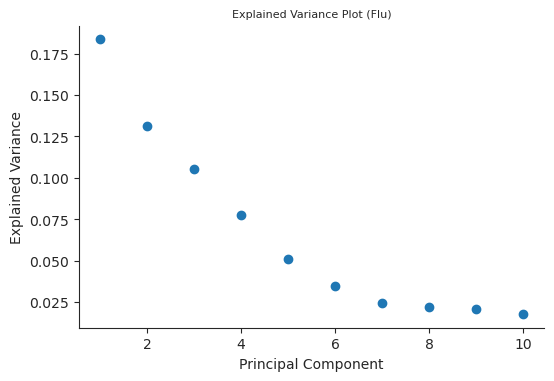

In [95]:
plt.plot(explained_variance_df['principal components'].values.tolist(), explained_variance_df["explained variance"].values.tolist(), 'o')

plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")

plt.title(f"Explained Variance Plot (Flu)")

#plt.savefig(snakemake.output.Explained_variance_PCA)

In [96]:
merged_pca_df = principalDf.merge(node_df[["strain", "date", "y", "outlier"]], on="strain")

In [97]:
merged_pca_df.head()

strain      pca1      pca2      pca3      pca4  \
0          A/Alabama/02/2016 -0.311700  0.695669 -0.173352 -2.331684   
1           A/Alaska/22/2016 -0.300252  0.679495 -0.090173 -2.277267   
2           A/Hawaii/47/2016 -0.306846  0.679546 -0.097809 -2.283201   
3           A/Alaska/23/2016 -0.306401  0.677695 -0.116357 -2.284220   
4  A/SouthAustralia/148/2016 -0.295850  0.676004 -0.111609 -2.281545   

       pca5      pca6      pca7      pca8      pca9     pca10  pca_label  \
0  0.308801 -0.287430  0.170795  0.569070 -0.277187  0.107602         -1   
1  0.435869 -0.255394  0.171194  0.715269 -0.229903  0.158829         -1   
2  0.365744 -0.321277  0.214529  0.694853 -0.211827  0.167366         -1   
3  0.374238 -0.322087  0.231428  0.688147 -0.206971  0.119157         -1   
4  0.427291 -0.293012  0.265479  0.656181 -0.173025  0.114636         -1   

      date    y      outlier  
0  2016.07  684  not_outlier  
1  2016.43  697  not_outlier  
2  2016.25  696  not_outlier  
3  2016.45  700  not_outlier  
4  2016.86  701  not_outlier

In [98]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

In [100]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "outlier:N",['strain', "outlier"], domain, range_)
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
#PCAFluBrush.save("../docs/PCAOutlierBrush.html")

alt.HConcatChart(...)

# Running MDS on the Dataset

In [354]:
MDS_df = pd.read_csv("results/embed_mds.csv",index_col=0)
outlier_df = pd.read_csv("results/outliers.csv")

In [355]:
merged_mds_df = MDS_df.merge(node_df[["strain", "date", "y", "outlier"]], on="strain")

In [356]:
merged_mds_df = merged_mds_df.merge(outlier_df[['strain', 'predicted_outlier_status']], on="strain")

In [357]:
merged_mds_df

strain        mds1        mds2  mds_label  \
0                   A/swine/IA/34208/2018  165.129917   38.058226         -1   
1                      A/Shiraz/1006/2015   15.209952 -110.414412         -1   
2                       A/Alabama/15/2016   -6.483664    8.174998          9   
3                     A/NewJersey/26/2016   -6.483850    8.175839          9   
4                      A/Michigan/07/2017   -7.695796    8.553672         -1   
...                                   ...         ...         ...        ...   
2593      A/swine/Virginia/A01785950/2019  143.770377  164.484536         -1   
2594          A/swine/Ontario/SD0298/2018  207.935677  -11.770534         -1   
2595  A/swine/BritishColumbia/SD0286/2018  188.905598 -113.460845         -1   
2596     A/swine/Saskatchewan/SD0271/2018  192.032535   91.909391         -1   
2597     A/swine/Minnesota/A01785788/2018  134.072626 -162.400055         -1   

         date     y      outlier  predicted_outlier_status  
0     2018.35    23      outlier                      -1.0  
1     2015.81    24  not_outlier                       1.0  
2     2016.88  1888  not_outlier                       1.0  
3     2016.88  1891  not_outlier                       1.0  
4     2017.03  1887  not_outlier                       1.0  
...       ...   ...          ...                       ...  
2593  2019.10     8      outlier                       1.0  
2594  2018.33     6      outlier                      -1.0  
2595  2018.27     2      outlier                      -1.0  
2596  2018.18     3      outlier                       1.0  
2597  2018.95     1      outlier                      -1.0  

[2598 rows x 8 columns]

In [358]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','outlier'],'outlier:N', domain, range_)
#chart_34_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds3','mds4',"mds3","mds4",['strain','outlier'],'outlier:N', domain, range_)
#chart_56_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds5','mds6',"mds5","mds6",['strain','outlier'],'outlier:N', domain, range_)
chart_12_mds#|chart_34_mds|chart_56_mds

alt.Chart(...)

In [359]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'outlier:N', ['strain','outlier'], domain, range_)
list_of_chart[0]|list_of_chart[1]

alt.HConcatChart(...)

In [360]:
mapping = {'not_outlier': 1, 'outlier': -1}

merged_mds_df = merged_mds_df.replace({'not_outlier': mapping, 'outlier': mapping})

In [361]:
domain =  ['-1', '1'] 
range_ = ['#FF0000','#000000']

In [371]:
merged_mds_df['outlier'].value_counts()

 1    2561
-1      37
Name: outlier, dtype: int64

In [363]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','outlier'],'predicted_outlier_status:N', domain, range_)
chart_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','outlier'],'outlier:N', domain, range_)
chart_12_mds|chart_mds

alt.HConcatChart(...)

In [364]:
from sklearn.metrics import accuracy_score
accuracy_score(merged_mds_df["outlier"].values.tolist(), merged_mds_df["predicted_outlier_status"].values.tolist())

0.9884526558891455

In [365]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef
matthews_corrcoef(merged_mds_df["outlier"].values.tolist(), merged_mds_df["predicted_outlier_status"].values.tolist())

0.5322470899753056

In [366]:
confusion_matrix(merged_mds_df["outlier"].values.tolist(), merged_mds_df["predicted_outlier_status"].values.tolist())

array([[  17,   20],
       [  10, 2551]])

/home/nandsra21/anaconda3/envs/cartography/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


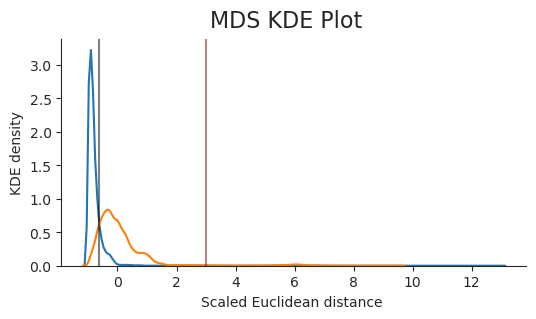

In [372]:
MDS_KDE_df = pd.read_csv("results/KDEDensity_mds.csv",index_col=0)
MDS_KDE_metadata_df = pd.read_csv("results/KDEDensity_mds_metadata.csv", index_col=0)
MDS_outlier_metadata_df = pd.read_csv("results/LOF_accuracy.csv")
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=MDS_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax.axvline(x=MDS_outlier_metadata_df["threshold"].values.tolist()[0], label="Outlier threshold", color="#800000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance ")
ax.set_ylabel("KDE density")

fig.suptitle('MDS KDE Plot', fontsize=16)
sns.despine()

# Running T-SNE on the Dataset 

In [108]:
TSNE_df = node_df[["strain", "date", "y", "outlier", "tsne_x", "tsne_y", "t-sne_label"]]

In [109]:
scatterplot_with_tooltip_interactive(TSNE_df,'tsne_x','tsne_y','tsne_x','tsne_y',['strain', "outlier"],'outlier:N', domain, range_)

alt.Chart(...)

In [110]:
list_of_chart = linking_tree_with_plots_brush(
    TSNE_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'outlier:N',
    ["strain:N"],
    domain,
    range_
)
chart_tsne = list_of_chart[0]|list_of_chart[1]
chart_tsne

alt.HConcatChart(...)

# Running UMAP on the Dataset

In [111]:
UMAP_df = node_df[["strain", "date", "y", "outlier", "umap_x", "umap_y"]]

In [112]:
scatterplot_with_tooltip_interactive(UMAP_df,'umap_x','umap_y','umap_x','umap_y',['strain'],'outlier:N', domain, range_)

alt.Chart(...)

In [113]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    UMAP_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'outlier:N',
    ["strain:N"],
    domain,
    range_
)
chart_umap = list_of_chart[0]|list_of_chart[1]
chart_umap
#chart.save("../docs/UMAPMERSBrush.html")

alt.HConcatChart(...)

# Linking all plots together clickable with Tree

In [119]:
data = linking_tree_with_plots_brush(
    node_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca1', 'pca2', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'outlier:N',
    ['strain'],
    domain,
    range_
)

In [ ]:
PCAMDS = data[3]|data[1]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.vconcat(data[0],embeddings)
fullChart
#fullChart.save("../docs/FullLinkedChartBrushableFluOutlier.html")
#fullChart
#fullChart.save(snakemake.output.fullChart)
#save(fullChart, "../docs/FullLinkedChartBrushableFluOutlier.png", scale_factor=2.0)
#save(fullChart, snakemake.output.fullChartPNG, scale_factor=2.0)